### Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
auto_train_ds = pd.read_csv("Train.csv", sep=",")
auto_test_ds = pd.read_csv("Test.csv", sep=",")
auto_ds = pd.concat([auto_train_ds, auto_test_ds])

auto_ds

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,B
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6,C
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,C


### Data Preliminary Exploration

In [126]:
#Checking the existence of zeros in rows
(auto_ds==0).sum(axis=0)

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience    3087
Spending_Score        0
Family_Size           0
Var_1                 0
Segmentation          0
dtype: int64

In [127]:
#Checking the existence of duplicated rows
auto_ds.duplicated().sum()

38

In [128]:
#Checking data balancing (for classification)
auto_balancing = pd.DataFrame()
auto_balancing["Count"] = auto_ds["Segmentation"].value_counts()
auto_balancing["Count%"] = auto_ds["Segmentation"].value_counts()/auto_ds.shape[0]*100

auto_balancing

,Count,Count%
D,3027,28.30
A,2818,26.35
C,2442,22.83
B,2408,22.52


In [129]:
#Checking basic statistical data by feature
auto_ds.describe(include="all")

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,"10,695.00",10695,10505,"10,695.00",10593,10533,"9,597.00",10695,"10,247.00",10587,10695
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,4
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,NaN,5841,6163,NaN,6570,3318,NaN,6494,NaN,6910,3027
mean,"463,468.09",NaN,NaN,43.51,NaN,NaN,2.62,NaN,2.84,NaN,NaN
std,"2,600.97",NaN,NaN,16.77,NaN,NaN,3.39,NaN,1.54,NaN,NaN
min,"458,982.00",NaN,NaN,18.00,NaN,NaN,0.00,NaN,1.00,NaN,NaN
25%,"461,220.50",NaN,NaN,30.00,NaN,NaN,0.00,NaN,2.00,NaN,NaN
50%,"463,451.00",NaN,NaN,41.00,NaN,NaN,1.00,NaN,3.00,NaN,NaN
75%,"465,733.50",NaN,NaN,53.00,NaN,NaN,4.00,NaN,4.00,NaN,NaN


### Data Cleaning


1. Remove duplicated rows (38 in total)

2. Treat missing values:
    *   3.1 Ever_Married: consider missing values as No
    *   3.2 Graduated: consider missing values as No
    *   3.3 Profession: delete (it´s not representative the amount of blanks)
    *   3.4 Family_Size: mean
    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
    *   3.6 Work_Experience: estimate based on Age


3. Remove column ID as it´s not important to the model

4. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies

In [130]:
#1
auto_ds.drop_duplicates(inplace=True)

In [131]:
#2
auto_ds["Ever_Married"].fillna("No", inplace=True)
auto_ds["Graduated"].fillna("No", inplace=True)
auto_ds.dropna(subset=["Profession"], inplace=True)
auto_ds["Family_Size"].fillna(auto_ds["Family_Size"].mean(), inplace=True)
auto_ds.dropna(subset=["Var_1"], inplace=True)
auto_ds["Work_Experience"].replace(0, np.nan, inplace=True)
auto_ds["Work_Experience"].fillna(auto_ds["Work_Experience"].sum() / auto_ds["Age"].sum() * auto_ds["Age"], inplace=True)

In [132]:
#3
auto_ds.drop(["ID"], axis=1, inplace=True)

In [133]:
#4
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Gender"], prefix="Gender")], axis=1)
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Ever_Married"], prefix="Ever_Married")], axis=1)
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Graduated"], prefix="Graduated")], axis=1)
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Profession"], prefix="Profession")], axis=1)
auto_ds["Spending_Score_Level"] = auto_ds["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Var_1"], prefix="Var_1")], axis=1)
#target variable for the ML model (label encoding)
auto_ds["Segmentation_Level"] = auto_ds["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
auto_ds = pd.concat([auto_ds, pd.get_dummies(auto_ds["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(auto_ds[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]]) #creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

### Features Selection

In [135]:
auto_ds.drop(["Segmentation", "Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"], axis=1, inplace=True)

Feature:Age, Score:0.0232
Feature:Work_Experience, Score:0.0033
Feature:Family_Size, Score:0.0043
Feature:Gender_Female, Score:0.0006
Feature:Gender_Male, Score:0.0005
Feature:Ever_Married_No, Score:0.0072
Feature:Ever_Married_Yes, Score:0.0060
Feature:Graduated_No, Score:0.0046
Feature:Graduated_Yes, Score:0.0047
Feature:Profession_Artist, Score:0.0061
Feature:Profession_Doctor, Score:0.0003
Feature:Profession_Engineer, Score:0.0007
Feature:Profession_Entertainment, Score:0.0009
Feature:Profession_Executive, Score:0.0003
Feature:Profession_Healthcare, Score:0.0071
Feature:Profession_Homemaker, Score:0.0003
Feature:Profession_Lawyer, Score:0.0004
Feature:Profession_Marketing, Score:0.0008
Feature:Spending_Score_Level, Score:0.0098
Feature:Var_1_Cat_1, Score:0.0002
Feature:Var_1_Cat_2, Score:0.0003
Feature:Var_1_Cat_3, Score:0.0004
Feature:Var_1_Cat_4, Score:0.0009
Feature:Var_1_Cat_5, Score:0.0001
Feature:Var_1_Cat_6, Score:0.0007
Feature:Var_1_Cat_7, Score:0.0002
Feature:Segmentation_

<AxesSubplot:>

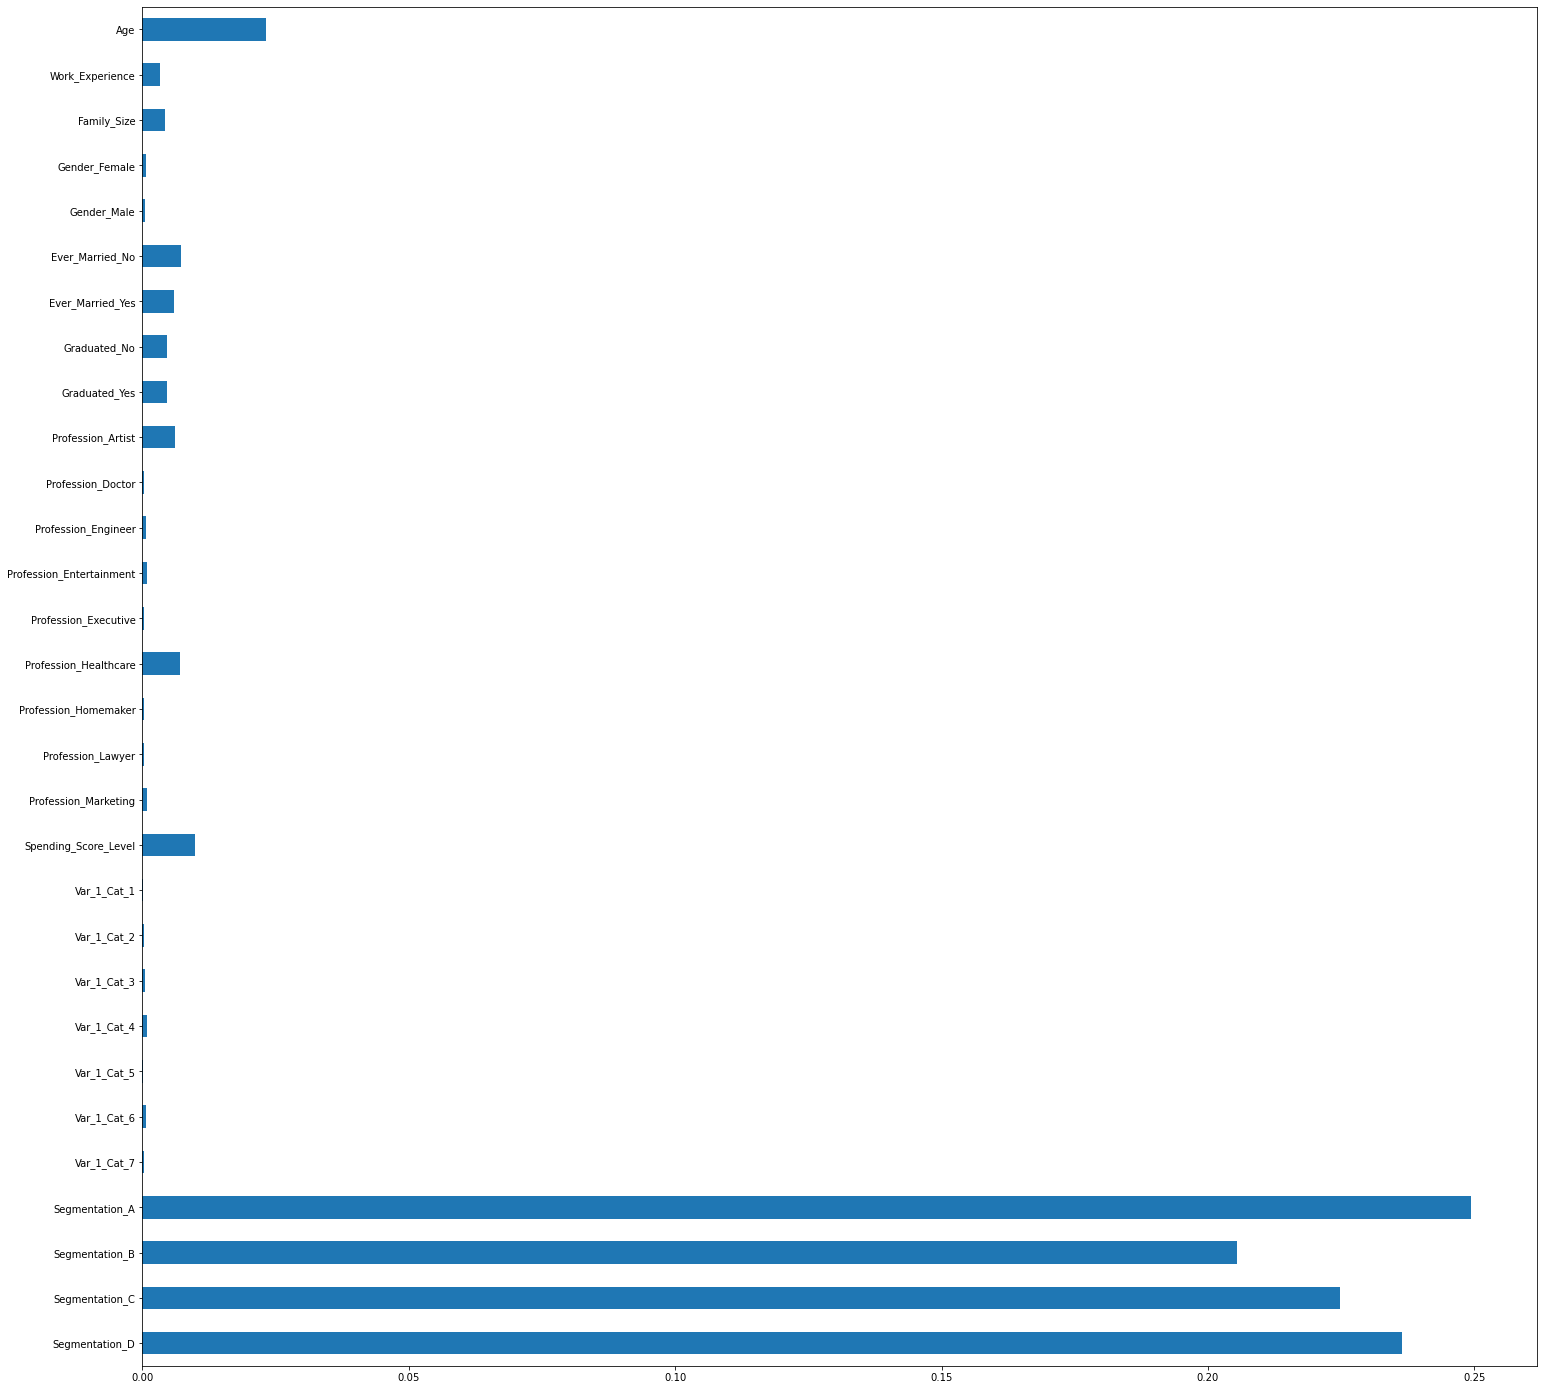

In [136]:
#Plotting a Feature Importance

from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
#Defining Xs and y
X = auto_ds.drop(["Segmentation_Level"], axis=1)
y = auto_ds["Segmentation_Level"]
#Defining the model
model = RandomForestClassifier().fit(X, y)
#Getting importance
importance = model.feature_importances_
#Summarizing feature importance
for i,v in enumerate(importance):
    print("Feature:{0:}, Score:{1:,.4f}".format(X.columns[i], v))
#Plotting feature importance
pd.Series(model.feature_importances_[::-1], index=X.columns[::-1]).plot(kind="barh", figsize=(25,25))

### Data Modelling

In [149]:
#Defining Xs and y

X = auto_ds[["Age", "Family_Size", "Profession_Healthcare", "Work_Experience", "Profession_Artist", "Ever_Married_Yes",
             "Graduated_No", "Spending_Score_Level"]]
y = auto_ds["Segmentation_Level"]
y_dl = Segmentation_encoding_dl #for the DL model

#Scaling all features

from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
X_scaled = sc_X.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

#Setting train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_scaled, y_dl, random_state=0) #for the DL model

### Machine learning

#### Logistic Regression

In [142]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

# Định nghĩa mô hình
model = linear_model.LogisticRegression(max_iter=1000)

# Huấn luyện mô hình trên tập huấn luyện
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
acc = accuracy_score(y_test, y_pred)

print('Accuracy:', acc)

Accuracy: 0.4565050038491147


#### K-Nearest Neighbors

In [146]:
from sklearn.neighbors import KNeighborsClassifier
k = 49
knn = KNeighborsClassifier(n_neighbors=k)
score = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy').mean()

print(f"The optimal number of neighbors is {k}")
print(score)

The optimal number of neighbors is 49
0.45944570619795266


#### Support Vector Machines (SVM)

In [147]:
from sklearn import svm

linear_svm = svm.SVC(kernel='linear')
linear_svm_score = cross_val_score(linear_svm, X_train, y_train, cv=10, scoring='accuracy').mean()
print(linear_svm_score)

0.43339620157335174


#### Linear and RBF Kernels

In [148]:
rbf = svm.SVC(kernel='rbf')
rbf_score = cross_val_score(rbf, X_train, y_train, cv=10, scoring='accuracy').mean()
print(rbf_score)

0.4639366709456568


### Deep Learning

In [151]:
#Creating a Deep Learning model and checking its Metrics

from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
pd.options.mode.chained_assignment = None

#Creating a model
model_dl = Sequential()

#Input and First Hidden Layer
model_dl.add(Dense(units=256, activation="relu", input_dim=X_train.shape[1]))
model_dl.add(Dropout(0.25))
model_dl.add(Dense(64, activation='relu'))
model_dl.add(Dropout(0.25))
model_dl.add(Dense(128, activation='relu'))
#Output Layer
model_dl.add(Dense(units=4, activation="softmax"))

#Compiling the neural network
model_dl.compile(optimizer="Adam", loss="CategoricalCrossentropy", metrics=["CategoricalAccuracy"])

#Fitting to the model
model_dl.fit(X_train_dl, y_train_dl, epochs=100, batch_size=32)

Epoch 1/100
244/244 [==============================] - 2s 3ms/step - loss: 1.2528 - categorical_accuracy: 0.4268
Epoch 2/100
244/244 [==============================] - 1s 3ms/step - loss: 1.2169 - categorical_accuracy: 0.4520
Epoch 3/100
244/244 [==============================] - 1s 3ms/step - loss: 1.2083 - categorical_accuracy: 0.4512
Epoch 4/100
244/244 [==============================] - 1s 3ms/step - loss: 1.2028 - categorical_accuracy: 0.4583
Epoch 5/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1991 - categorical_accuracy: 0.4605
Epoch 6/100
244/244 [==============================] - 1s 3ms/step - loss: 1.1925 - categorical_accuracy: 0.4618
Epoch 7/100
244/244 [==============================] - 1s 3ms/step - loss: 1.1943 - categorical_accuracy: 0.4643
Epoch 8/100
244/244 [==============================] - 1s 3ms/step - loss: 1.1872 - categorical_accuracy: 0.4750
Epoch 9/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1841 - categorical_

244/244 [==============================] - 1s 2ms/step - loss: 1.1441 - categorical_accuracy: 0.4918
Epoch 73/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1386 - categorical_accuracy: 0.4922
Epoch 74/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1441 - categorical_accuracy: 0.4914
Epoch 75/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1415 - categorical_accuracy: 0.4928
Epoch 76/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1396 - categorical_accuracy: 0.4924
Epoch 77/100
244/244 [==============================] - 1s 3ms/step - loss: 1.1371 - categorical_accuracy: 0.5027
Epoch 78/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1406 - categorical_accuracy: 0.4928
Epoch 79/100
244/244 [==============================] - 1s 3ms/step - loss: 1.1398 - categorical_accuracy: 0.4964
Epoch 80/100
244/244 [==============================] - 1s 2ms/step - loss: 1.1414 - categorical_accu

In [154]:
score = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print('Độ chính xác của mô hình là:', score[1])

Độ chính xác của mô hình là: 0.47305619716644287


In [155]:
#Fitting to the model
model_dl.fit(X_train_dl, y_train_dl, epochs=200, batch_size=32)

Epoch 1/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1318 - categorical_accuracy: 0.4960
Epoch 2/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1308 - categorical_accuracy: 0.4999
Epoch 3/200
244/244 [==============================] - 1s 3ms/step - loss: 1.1316 - categorical_accuracy: 0.4965
Epoch 4/200
244/244 [==============================] - 1s 3ms/step - loss: 1.1302 - categorical_accuracy: 0.5014
Epoch 5/200
244/244 [==============================] - 1s 3ms/step - loss: 1.1296 - categorical_accuracy: 0.5008
Epoch 6/200
244/244 [==============================] - 1s 3ms/step - loss: 1.1304 - categorical_accuracy: 0.5013
Epoch 7/200
244/244 [==============================] - 1s 3ms/step - loss: 1.1296 - categorical_accuracy: 0.4981
Epoch 8/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1268 - categorical_accuracy: 0.5024
Epoch 9/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1301 - categorical_

244/244 [==============================] - 1s 2ms/step - loss: 1.1062 - categorical_accuracy: 0.5158
Epoch 73/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1076 - categorical_accuracy: 0.5176
Epoch 74/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1067 - categorical_accuracy: 0.5178
Epoch 75/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1114 - categorical_accuracy: 0.5063
Epoch 76/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1050 - categorical_accuracy: 0.5083
Epoch 77/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1068 - categorical_accuracy: 0.5110
Epoch 78/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1055 - categorical_accuracy: 0.5185
Epoch 79/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1053 - categorical_accuracy: 0.5131
Epoch 80/200
244/244 [==============================] - 1s 2ms/step - loss: 1.1027 - categorical_accu

244/244 [==============================] - 1s 3ms/step - loss: 1.0895 - categorical_accuracy: 0.5200
Epoch 144/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0840 - categorical_accuracy: 0.5235
Epoch 145/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0937 - categorical_accuracy: 0.5185
Epoch 146/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0917 - categorical_accuracy: 0.5178
Epoch 147/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0920 - categorical_accuracy: 0.5169
Epoch 148/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0909 - categorical_accuracy: 0.5175
Epoch 149/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0839 - categorical_accuracy: 0.5218
Epoch 150/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0880 - categorical_accuracy: 0.5249
Epoch 151/200
244/244 [==============================] - 1s 3ms/step - loss: 1.0864 - categori

In [156]:
score = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print('Độ chính xác của mô hình là:', score[1])

Độ chính xác của mô hình là: 0.4668976068496704


In [158]:
print("Shape of the Dataset:", X_train_dl.shape)

Shape of the Dataset: (7792, 8)
